# Anàlisi d'estacionarietat de dades temporals en models de Simulació d'Esdeveniments Discrets

## Exemple: dades de les recollides de clients en el sistema de taxi (Yellow cab) de Nova York

En aquest exemple s'analitza el comportament del temps entre el temps entre la recollida de clients
en el sistema de taxis de Nova York. Per nosaltres en un model de simulació d'esdeveniments discrets
això seria equivalent al temps entre arribades de clients al sistema. Els taxis de Nova York deixen
públiques les seves dades i es poden consultar i analitzar. En aquest estudi s'analitza l'estabilitat
temporal de les dades i es veu si aquestes estan idènticament distribuïdes per tot el període d'estudi.

Per fer aquesta anàlisi es divideix en la següent seqüència d'accions:

- Importar les dades amb *pandas*
- Filtrar les dades per dos dies (per reduir-ne el volum) i calcular el temps entre arribades.
- Càlcul del nombre d'arribades per segon, acumulat i per probabilitat (per poder mostrar la gràfica p-p).
- Mostrar la gràfica p-p.
- Mostrar un gràfic de barres de les arribades horàries

In [6]:
# Import the necessary libraries from the beginning
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import f_oneway

In [2]:
# Load the Yellow Cab NYC taxi data
df = pd.read_csv("yellow-tripdata-2025-01.csv", usecols=["tpep_pickup_datetime"])
df.rename(columns={'tpep_pickup_datetime': 'arrival_time'}, inplace=True)
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
# Filter for 14th and 15th of January just to reduce the data set length
from_ts = datetime.datetime(2025,1,14,0,0,0)
to_ts = datetime.datetime(2025,1,16,0,0,0)
df = df[(from_ts <= df['arrival_time']) & ( df['arrival_time'] < to_ts)]
# Compute interarrival time
df.sort_values('arrival_time', inplace=True)
df['interarrival'] = df['arrival_time'].diff().dt.total_seconds()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,arrival_time,interarrival
0,2025-01-14 00:00:02,1.0
1,2025-01-14 00:00:02,0.0
2,2025-01-14 00:00:04,2.0
3,2025-01-14 00:00:19,15.0
4,2025-01-14 00:00:26,7.0


In [3]:
# Create the data needed to show a p-p graph
# Count arrivals for each second in both days
counts = df['arrival_time'].value_counts().sort_index()
counts_df = counts.reset_index()
counts_df.columns = ['date', 'count']
counts_df['date'] = pd.to_datetime(counts_df['date'])
# Create a data frame with each second and the arrival count in that second
number_of_seconds = 24 * 60 * 60 * 2
pp_df = pd.DataFrame()
pp_df['second'] = range(0, number_of_seconds)
pp_df['arrivals_count'] = 0
for index, row in counts_df.iterrows():
    second = row['date'].hour * 3600 + row['date'].minute * 60 + row['date'].second + 86400 * (row['date'].day - 14)
    pp_df.loc[second, 'arrivals_count'] = row['count']
# Compute cumulative values
pp_df['cumulative_arrivals'] = pp_df['arrivals_count'].cumsum()
# Compute proportions for the p-p graph
pp_df['pp_x'] = pp_df['second'] / pp_df['second'].max()
pp_df['pp_y'] = pp_df['cumulative_arrivals'] / pp_df['cumulative_arrivals'].max()
print(pp_df)

        second  arrivals_count  cumulative_arrivals      pp_x      pp_y
0            0               0                    0  0.000000  0.000000
1            1               0                    0  0.000006  0.000000
2            2               2                    2  0.000012  0.000008
3            3               0                    2  0.000017  0.000008
4            4               1                    3  0.000023  0.000012
...        ...             ...                  ...       ...       ...
172795  172795               0               247090  0.999977  0.999988
172796  172796               1               247091  0.999983  0.999992
172797  172797               1               247092  0.999988  0.999996
172798  172798               1               247093  0.999994  1.000000
172799  172799               0               247093  1.000000  1.000000

[172800 rows x 5 columns]


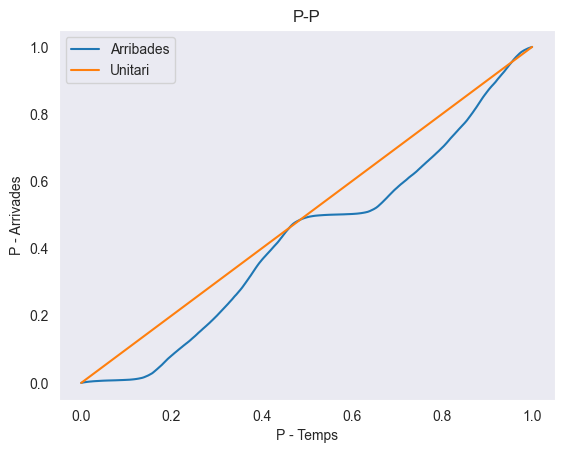

In [4]:
# Show the p-p graph
plt.plot(pp_df['pp_x'], pp_df['pp_y'], label='Arribades')
plt.plot([0, 1], [0, 1], label='Unitari')
plt.title("P-P")
plt.xlabel('P - Temps')
plt.ylabel('P - Arrivades')
plt.legend()
plt.grid()
plt.show()

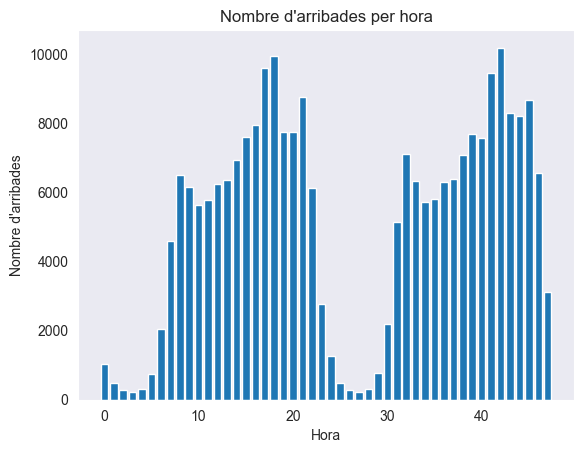

In [5]:
# Create an hourly number of arrivals data frame
pp_df['hour'] = pp_df['second'] // 3600
hour_df = pp_df.groupby('hour').sum()
hour_df = hour_df['arrivals_count']
plt.bar(hour_df.index, hour_df)
plt.title("Nombre d'arribades per hora")
plt.xlabel('Hora')
plt.ylabel("Nombre d'arribades")
plt.grid()

# Anàlisi dels resultats obtinguts

Observant les dades graficades es pot veure clarament que tant les peticions horàries de taxis (diagrama de barres) com amb
la gràfica p-p (probabilitats) les peticions de taxi no estan idènticament distribuïdes.

En el gràfic p-p s'aprecia que no segueix la proporcionalitat 1:1, durant la nit hi ha poques arribades (pendent < 1)
i a mesura que el dia avança les arribades creixen (pendent > 1). Amb la gràfica de barres s'aprecia el mateix comportament.

En aquest cas observant les gràfiques ja es pot determinar que serà impossible de trobar patrons comuns. Per tant per modelar amb
una distribució de densitat de probabilitat les arribades caldrà utilitzar la mitjana d'arribades per hora (la taxa d'arribades es
modela amb una distribució de Poisson) si volem el temps entre arribades que demana Arena, cal fer la inversa i usar una distribució
exponencial del temps mitjà entre arribades. No hi ha gaire més a fer, fer d'altres anàlisis seria perdre el temps.

També es pot fer un test d'Estacionarietat: Augmented Dickey–Fuller test

Podeu aprendre'n més a:

- [Augmented Dickey–Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)
- [Arrel unitària](https://en.wikipedia.org/wiki/Unit_root)
- [Procés estacionari](https://en.wikipedia.org/wiki/Stationary_process)

In [13]:
# Compute the ADF Test
result = adfuller(df['interarrival'])
# Show the results
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.044126375699745
p-value: 1.8137137179138182e-12


## Les dades reals no són mai simples d'utilitzar

Trobar un conjunt de dades reals amb temps d'arribada estacionaris pot ser complicat perquè la majoria dels sistemes reals
(com el trànsit, urgències hospitalàries, transaccions bancàries, etc.) presenten un comportament no estacionari a
causa dels efectes del comportament humà.

## I l'estabilitat de la duració del trajecte? El trajecte depèn també de l'hora?

Doncs en una primera hipòtesi es podria pensar que la duració del trajecte en el taxi s'hauria de comportar estacionàriament,
per tan, independentment de l'hora del dia. Però sense una anàlisi ni estudi de dades, això és simplement una conjectura. Fem un estudi
similar a l'anterior:

Primer cal triar una divisió temporal d'anàlisi. Com que no sabem si les dades són o no són estacionàries o com segmentar els temps:
per dies, per hores, per minuts. Cal fer una primera hipòtesi. Com dividim el temps? Com que l'ésser humà s'organitza principalment en dies
i hores sembla lògic dividir les dades amb aquestes unitats, per tant mostrem les dades del trajecte d'un dia amb una base horària. Abans de fer
una anàlisi quantitativa observem les dades qualitativament.

In [3]:
# Read the data
df = pd.read_csv("yellow-tripdata-2025-01.csv", usecols=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
df.rename(columns={'tpep_pickup_datetime': 'arrival_time'}, inplace=True)
df.rename(columns={'tpep_dropoff_datetime': 'finish_time'}, inplace=True)
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])
# Filter for 14th of January to test one random day
from_ts = datetime.datetime(2025,1,14,0,0,0)
to_ts = datetime.datetime(2025,1,15,0,0,0)
df = df[(from_ts <= df['arrival_time']) & ( df['arrival_time'] < to_ts)]
df['hour'] = df['arrival_time'].dt.hour
df['length'] = (df['finish_time'] - df['arrival_time']).dt.total_seconds()
df.head()

,arrival_time,finish_time,hour,length
109889,2025-01-14 00:01:11,2025-01-14 00:05:19,0,248.0
110076,2025-01-14 00:11:26,2025-01-15 00:10:21,0,86335.0
110462,2025-01-14 00:12:15,2025-01-14 00:20:10,0,475.0
110463,2025-01-14 00:47:18,2025-01-14 00:52:59,0,341.0
110464,2025-01-14 00:42:08,2025-01-14 01:02:53,0,1245.0


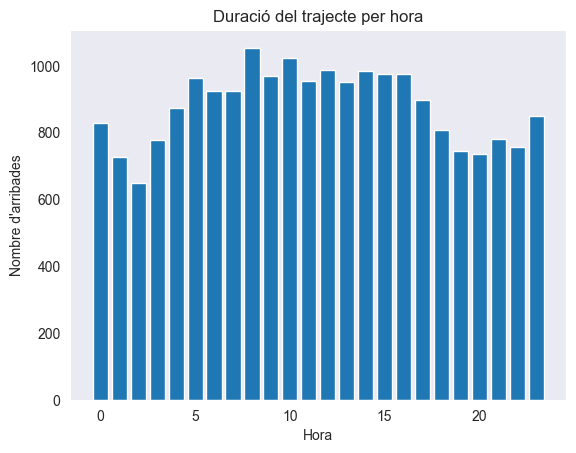

In [7]:
hour_df = df.groupby('hour').mean()
# Create an hourly number of arrivals data frame
plt.bar(hour_df.index, hour_df['length'])
plt.title("Duració del trajecte per hora")
plt.xlabel('Hora')
plt.ylabel("Nombre d'arribades")
plt.grid()

A simple vista sembla que sí hi ha un comportment diferent en la duració del trajecte mitjà en funció de l'hora del dia.
La duració del trajecte mitjà a les 2 de la matinada és d'aproximadament 650 segons (10 minuts) mentre que a les 8 del matí
la duració mitjana s'enfila per sobre els 1000 segons (16 minuts). Factors com el trànsit o desplaçaments a i des dels aeroports
de la ciutat afecten la duració del trajecte mitja. També pot ser un comportament molt normal que de nit sí que s'utilitzi el taxi
per fer trajectes curts que no es plantejarien de dia.

Analitzem doncs un mes. De totes maneres no utilitzem totes les dades ja que els festius en mig de la setmana poden alterar les
dades. Així doncs, fem un filtratge de les dades que ens poden causar problemes. Dades que analitzaríem de manera diferent.

Busquem el temps mitjà de recorregut per dia i hora i les grafiquem amb un diagrama de barres

In [97]:
# Read the data
df = pd.read_csv("yellow-tripdata-2025-01.csv", usecols=["tpep_pickup_datetime", "tpep_dropoff_datetime"])
df.rename(columns={'tpep_pickup_datetime': 'arrival_time'}, inplace=True)
df.rename(columns={'tpep_dropoff_datetime': 'finish_time'}, inplace=True)
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])
# Remove strange data, probably time zones
df = df[~(df['arrival_time'] < datetime.datetime(2025,1,1,0,0,0))]
df = df[~(df['finish_time'] < datetime.datetime(2025,1,1,0,0,0))]
# Remove holidays
df = df[df['arrival_time'] >= datetime.datetime(2025,1,2,0,0,0)]
df = df[~((df['arrival_time'] >= datetime.datetime(2025,1,20,0,0,0)) & (df['arrival_time'] < datetime.datetime(2025,1,21,0,0,0)))]
df.sort_values('arrival_time', inplace=True)
df['day'] = df['arrival_time'].dt.weekday
df['hour'] = df['arrival_time'].dt.hour
df['length'] = (df['finish_time'] - df['arrival_time']).dt.total_seconds()
df.head()

,arrival_time,finish_time,day,hour,length
990744,2025-01-02 00:00:02,2025-01-02 00:14:28,3,0,866.0
991000,2025-01-02 00:00:05,2025-01-02 00:08:57,3,0,532.0
990540,2025-01-02 00:00:06,2025-01-02 00:05:22,3,0,316.0
2950915,2025-01-02 00:00:08,2025-01-02 00:16:15,3,0,967.0
990359,2025-01-02 00:00:10,2025-01-02 00:15:40,3,0,930.0


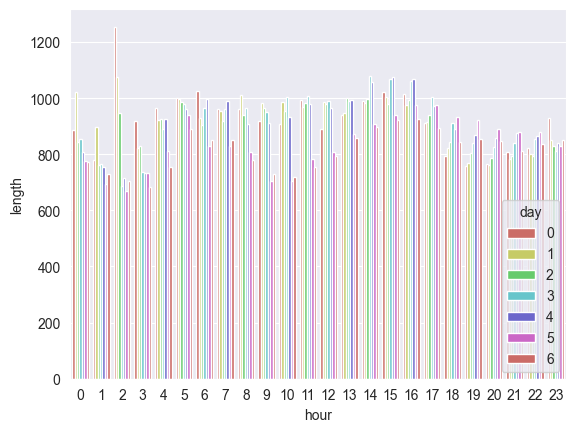

In [10]:
hour_df = df.groupby(['day', 'hour']).agg({"length": "mean"}).reset_index()
# Create an hourly number of arrivals data frame
bp = sns.barplot(x=hour_df['hour'], y=hour_df['length'], hue=hour_df['day'], palette="hls", legend="brief")
sns.move_legend(bp, "lower right")

D'aquesta gràfica s'observa clarament dos patrons molt diferenciats entre els laborables (dies número 0 a 4) i els festius (dies número 5 i 6).

Hi ha variacions també entre els dies laborables, sobretot a la nit, i també es pot veure que hi ha algunes diferències entre dilluns nit i
divendres nit respecte els altres laborables.

Fem un estudi primer diari per veure quins dies poden ser considerats iguals i quins poden ser considerats diferents. Com que fins ara solament
hem analitzat el mes de gener (per tenir un conjunt de dades reduït, en què els processos de càlcul no triguin molt de temps) usarem ara
les dades de tot un any, el 2024. Per limitar el volum les dades ja estan filtrades i contenen solament l'instant d'inici i finalització del
trajecte

Perquè tingueu un ordre de magnitud les dades de gener són 3.294.922, més de tres milions de desplaçaments. Per l'any 2024 són un total de
40.186.838 de desplaçaments.

1. En primer lloc, es cre el conjunt de dades al què s'hi afegeix el dia de la setmana i la setmana de l'any

In [4]:
# Read the data
df = pd.read_csv("taxi-nyc-2024.csv")
# Convert to datetime
df['arrival_time'] = pd.to_datetime(df['arrival_time'])
df['finish_time'] = pd.to_datetime(df['finish_time'])
# Remove inconsistencies
df = df[~(df['arrival_time'] >= datetime.datetime(2025, 1, 1, 0, 0, 0))]
# Create Day of the week (0=monday, 6=sunday); Week of the year; Length and the trip duration
df['day'] = df['arrival_time'].dt.weekday
df['week'] = df['arrival_time'].dt.isocalendar().week
df['length'] = (df['finish_time'] - df['arrival_time']).dt.total_seconds()
# isocalendar function assigns the first week of 2025 = last week of 2024, so 30 and 31 of december 2024 have to be corrected
df.loc[df.index[-2], 'week'] = df.loc[df.index[-3], 'week'] + 1
df.loc[df.index[-1], 'week'] = df.loc[df.index[-3], 'week'] + 1
df.head()

,Unnamed: 0,arrival_time,finish_time,day,week,length
0,0,2024-01-02 00:00:00,2024-01-02 07:22:04,1,1,26524.0
1,1,2024-01-02 00:00:01,2024-01-02 00:10:01,1,1,600.0
2,2,2024-01-02 00:00:04,2024-01-02 00:07:11,1,1,427.0
3,3,2024-01-02 00:00:07,2024-01-02 00:14:34,1,1,867.0
4,4,2024-01-02 00:00:08,2024-01-02 00:15:28,1,1,920.0


2. Es mostra en una gràfica la duració mitjana del trajecte en funció del dia de la setmana

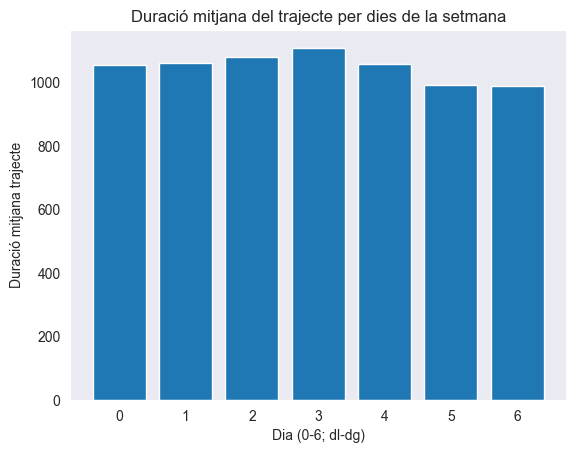

In [5]:
# Compute the day of the week length average
day_df = df.groupby('day').mean()
day_df.head()
# Graph it
plt.bar(day_df.index, day_df['length'])
plt.title("Duració mitjana del trajecte per dies de la setmana")
plt.xlabel('Dia (0-6; dl-dg)')
plt.ylabel("Duració mitjana trajecte")
plt.grid()

Es pot apreciar a la gràfica que els recorreguts mitjans són força similars però es veu certa diferència en els dissabtes i diumenges i
la resta de dies i també sembla diferent el dijous.

PEr estar segurs fem un test ANOVA per saber si podem considerara les mitjanes iguals en funció del dia

In [11]:
samples = [df.loc[df['day'] == i]['length'] for i in range(7)]
result = f_oneway(*samples)
print(result)

F_onewayResult(statistic=np.float64(2723.669221644114), pvalue=np.float64(0.0))


El p-valor de 0, menor a 0.05 indica que es pot rebutjar H0 i per tant considerar les mitjanes diferents. Però com sabem què és
igual i què diferent?

Hi ha diferents maneres de comprovar aquesta igualtat o diferència, més o menys complexes, se n'ha triat una de simple, que no és
la millor, però és molt entenedora.

S'utilitzarà una regressió linial per veure quins dies de la setmana expliquen millor la duració del trajecte. Així els dies
que no tenen significància estadística dins la regressió, són dies que són tan similars a d'altres que aquests altres els poden
explicar. Quan passa això és que tenen el mateix (o molt similar) comportament.

3. Es calcula el valor mitjà de la duració del trajecte segons dia de la setmana i setmana de l'any

In [12]:
week_day_df = df.groupby(['week', 'day']).mean()
week_day_df.reset_index(inplace=True)
week_day_df = week_day_df[['week', 'day', 'length']]
week_day_df.to_csv('week_day_2024.csv')
print(week_day_df)

     week  day       length
0       1    0  1117.211641
1       1    1   956.703314
2       1    2   989.766593
3       1    3   962.551783
4       1    4   920.606205
..    ...  ...          ...
348    52    1   921.190743
349    52    3  1109.813912
350    52    4  1127.911158
351    52    5  1081.336708
352    52    6  1076.780534

[353 rows x 3 columns]


4. Per poder fer la regressió linial es creen 6 variables categòriques per representar els 7 dies de la setmana. Sí 6, per què si es fessin 7 variables no hi hauria independència. La 7a variable serà el terme independent de la regressió.

Aquestes variables les anomenarem Q2, Q3, ... , Q7. Q1 no existeix per què serà el terme independent

Assignem al dia 0 (dilluns) Q2 = 0, Q3 = 0, ... Q7 = 0 fent que el dilluns sigui el terme independent

Assignem al dia 1 (dimarts) Q2 = 1, Q3 = 0, ... Q7 = 0 Si el coeficient de la regressió de Q2 fos 0 voldria dir que Q2 no importa i com que la resta de Qa
és 0 voldria dir que dimarts és "igual" a dilluns. En lloc de fixar-nos en el valor del coeficient, per què no sabrem exactament les magnituds dels valors
ens fixarem en el seu p-value, si és < 0.05 serà significatiu a la regressió (dilluns i dimarts són diferents) si p-value > 0.05 és que no és significatiu
(dilluns i dimarts són iguals).

Assignem al dia 2 (dimecres) Q2 = 1, Q3 = 1, Q4 = 0, ... Q7 = 0 Amb aquests valors s'estudia com és de significatiu Q3 respecte els altres dies.

Anem fent el mateix per els altres Qs



In [161]:
# Each day of the week has a Categorical combination
avg_df = week_day_df.groupby('day').mean()
avg_df.reset_index(inplace=True)
avg_df = avg_df[['day', 'length']]
# These are column vectors!!
avg_df['Q2'] = [0, 1, 1, 1, 1, 1, 1]
avg_df['Q3'] = [0, 0, 1, 1, 1, 1, 1]
avg_df['Q4'] = [0, 0, 0, 1, 1, 1, 1]
avg_df['Q5'] = [0, 0, 0, 0, 1, 1, 1]
avg_df['Q6'] = [0, 0, 0, 0, 0, 1, 1]
avg_df['Q7'] = [0, 0, 0, 0, 0, 0, 1]
print(avg_df.head)

<bound method NDFrame.head of    day       length  Q2  Q3  Q4  Q5  Q6  Q7
0    0  1050.571231   0   0   0   0   0   0
1    1  1054.547439   1   0   0   0   0   0
2    2  1074.390485   1   1   0   0   0   0
3    3  1103.981129   1   1   1   0   0   0
4    4  1051.289604   1   1   1   1   0   0
5    5   989.056590   1   1   1   1   1   0
6    6   984.249175   1   1   1   1   1   1>


5. Una vegada fetes les Q (variables categòriques) reordenem els dies en funció de la duració mitjana del trajecte. Per què? Doncs
per què valors similars de la mitjana segurament implicarà dies similars.

Aquesta reordenació s'haurà de tenir present quan s'analitzin els resultats

In [168]:
avg_df.sort_values('length', inplace=True)
print(avg_df)

   day       length  Q2  Q3  Q4  Q5  Q6  Q7
6    6   984.249175   1   1   1   1   1   1
5    5   989.056590   1   1   1   1   1   0
0    0  1050.571231   0   0   0   0   0   0
4    4  1051.289604   1   1   1   1   0   0
1    1  1054.547439   1   0   0   0   0   0
2    2  1074.390485   1   1   0   0   0   0
3    3  1103.981129   1   1   1   0   0   0


6. Es repeteix el patró per les 52 setmanes de l'any (2024)

S'afegeix un valor t i un t quadrat per si es vol donar valors al model de regressió (valor linial i quadràtic), tot i que per aquest test no es farà servir.

Com que del conjunt inicial no hi ha els festius entre setmana, també s'eliminen del patró.

In [179]:
all = list()
for i in range(52):
    all.append(avg_df)
avg_df_repeated = pd.concat(all)
avg_df_repeated.reset_index(inplace=True)
avg_df_repeated['t'] = range(1, len(avg_df_repeated) + 1)
avg_df_repeated['t2'] = avg_df_repeated['t'] ** 2
week_holidays = [datetime.datetime(2024,1,15,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,2,19,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,5,27,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,6,19,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,7,4,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,9,2,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,10,14,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,11,5,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,11,11,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,11,28,0,0,0).timetuple().tm_yday - 1,
    datetime.datetime(2024,12,25,0,0,0).timetuple().tm_yday - 1,
]
avg_df_repeated = avg_df_repeated[~avg_df_repeated.index.isin(week_holidays)]
avg_df_repeated.reset_index(inplace=True)
print(avg_df_repeated)

     level_0  index  day       length  Q2  Q3  Q4  Q5  Q6  Q7    t      t2
0          0      6    6   984.249175   1   1   1   1   1   1    1       1
1          1      5    5   989.056590   1   1   1   1   1   0    2       4
2          2      0    0  1050.571231   0   0   0   0   0   0    3       9
3          3      4    4  1051.289604   1   1   1   1   0   0    4      16
4          4      1    1  1054.547439   1   0   0   0   0   0    5      25
..       ...    ...  ...          ...  ..  ..  ..  ..  ..  ..  ...     ...
348      358      5    5   989.056590   1   1   1   1   1   0  359  128881
349      360      4    4  1051.289604   1   1   1   1   0   0  361  130321
350      361      1    1  1054.547439   1   0   0   0   0   0  362  131044
351      362      2    2  1074.390485   1   1   0   0   0   0  363  131769
352      363      3    3  1103.981129   1   1   1   0   0   0  364  132496

[353 rows x 12 columns]


7. Es fa la regressió entre els valors de la duració del trajecte mitjà per setmana de l'any i dia de la setmana. Així Y és la duració i X són les variables categòriques a la que s'hi afegeix un terme independent.

In [202]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

y = week_day_df['length']
x = avg_df_repeated[['Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']]
x = sm.add_constant(x)

est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     18.50
Date:                Sat, 24 May 2025   Prob (F-statistic):           1.17e-18
Time:                        01:24:41   Log-Likelihood:                -2008.1
No. Observations:                 353   AIC:                             4030.
Df Residuals:                     346   BIC:                             4057.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1074.3905     10.215    105.179      0.0

Del resultat de la regressió es veu que Q7 és la menys significativa (p-value = 0.787), per tant l'eliminem.

Es torna a fer la regressió ara sense Q7.

La regressió es torna a fer sempre per tal que poder comprovar que les significàncies de cada variable categòrica no canvia.

In [203]:
import statsmodels.api as sm

y = week_day_df['length']
x = avg_df_repeated[['Q2', 'Q3', 'Q4', 'Q5', 'Q6']]
x = sm.add_constant(x)

est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())
print(est2.params)

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     22.24
Date:                Sat, 24 May 2025   Prob (F-statistic):           2.42e-19
Time:                        01:29:18   Log-Likelihood:                -2008.2
No. Observations:                 353   AIC:                             4028.
Df Residuals:                     347   BIC:                             4052.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1074.3905     10.201    105.320      0.0

Q4 és la menys significativa. S'elimina i es torna a fer la regressió.

In [204]:
import statsmodels.api as sm

y = week_day_df['length']
x = avg_df_repeated[['Q2', 'Q3', 'Q5', 'Q6']]
x = sm.add_constant(x)

est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     27.84
Date:                Sat, 24 May 2025   Prob (F-statistic):           4.52e-20
Time:                        01:29:36   Log-Likelihood:                -2008.2
No. Observations:                 353   AIC:                             4026.
Df Residuals:                     348   BIC:                             4046.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1074.3905     10.188    105.454      0.0

Q2 és la menys significativa, s'elimina i es torna a fer la regressió.

In [205]:
import statsmodels.api as sm

y = week_day_df['length']
x = avg_df_repeated[['Q3', 'Q5', 'Q6']]
x = sm.add_constant(x)

est = sm.OLS(y, x)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     36.08
Date:                Sat, 24 May 2025   Prob (F-statistic):           2.47e-20
Time:                        01:30:08   Log-Likelihood:                -2009.6
No. Observations:                 353   AIC:                             4027.
Df Residuals:                     349   BIC:                             4043.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1062.6136      7.150    148.622      0.0

Finalment ja no hi ha cap Q amb un p-value > 0.05 i ja es té el resultat definitiu.

## Anàlisi del resultat

const és el terme independent, equivalent a un Q1 que no es podia posar, Q2 no hi és per tan Q2 és similar a const. Però atenció!!
Els patrons s'han reordenat i els dies són 6, 5, 0, 4, 1, 2, 3 (dg, ds, dl, dv, dm, dx, dj). Així doncs Diumenge i Dissabte són similars.

Després tenim Q3 però no Q4, amb la reordenació vol dir que són també similars Dilluns i Divendres

A continuació tenim Q5, però sí que hi ha Q6, per tan, Dimarts va sol.

Finalment tenim Q6 però no Q7. Dimecres i Dijous són iguals!

Tot i que sembli que la reordenació ha afegit complexitat, és el contrari. Al reordenar les similituds estan adjacents i la interpretació és més fàcil.

## Com continuar l'estudi

Es començaria amb dissabte i diumenge que s'agruparien. Es faria el mateix estudi però de forma horària per saber quines hores es comporten igual i ara sí,
quan es tinguí les hores iguals es buscaria la distribució de densitat de probabilitat per els dissabtes i diumenges de 05:00 a 08:00, per posar
un exemple.

En Arena es modelaria una taula amb les distribucions, al "Delay" del trajecte del taxi s'accediria a la taula en funció del dia de la setmana i hora del dia.